## Getting the data


In [2]:
## Don't run it again since it takes too long to fetch the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [3]:
list(mnist)

['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url']

In [4]:
X, y = mnist[ 'data' ], mnist['target']
X.shape

(70000, 784)

In [5]:
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, interpolation='nearest', cmap='gray')
y[36000]  # What the digit actually is

'9'

### The dataset is already broken into training and test sets
Traning set is the first 60000 data, and test set is the rest

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Shuffling the training set, in case the data was saved in a nice order

In [7]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Goal: to identify the digit 9 using a binary classifier

In [8]:
goal_digit = '5'

In [9]:
## A vector with booliean values: True or False depending on whether
# the digit is 5 or not
# since '5' is a string so far. Wanted to make the dataset a pandas frame but  we are not doing that here
y_train_9 = (y_train == goal_digit)
y_test_9 = (y_test == goal_digit)

# checking that there are two categories, True and False
np.unique(y_train_9)

array([False,  True])

### Using a Stochastic Gradient Descent classifier to train it
The classifier `SGDClassifier` can handle very large dataset
because it handles training instances independently (what does that mean?)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=43, tol=53)
# we are training the binary classifier to recognise 5
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=43, shuffle=True, tol=53,
       validation_fraction=0.1, verbose=0, warm_start=False)

## Testing if the model can predict that digit

In [11]:
sgd_clf.predict([some_digit])

array([False])

### It cannot predict that particular digit right

In [12]:
y[36000]

'9'

### Let us find all occurance of nines as see how many are correct
Note: the following measurement is incorrect conceptually since it computes (total predicted positive)/(total actual positive) and does not consider when a predicted positive is an actual posive etc. See *confusion matrix* below for a correct measurement.

In [13]:
all_nines = np.where(y == goal_digit)
all_nines

(array([    0,    11,    35, ..., 69982, 69988, 69998]),)

In [14]:
sum( sgd_clf.predict(X[all_nines]) )/ sum(y == goal_digit)

0.9089181054965944

 So, not very good, around 50% predictions for digit 9 and around 77% accuracy for digit 5, even in the trainting set

### We measure the accuracy using Cross-validation
Here, as an utility function, we use `accuracy` instead of `neg_mean_squared_error`.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.9631 , 0.96445, 0.96615])

Here, as a part of success, we also include every time the model successfully recognises that a given picture is not the goal_digit. So, the score is higher.

### Surprising observation:
If we create a model that trivially ouputs 'not the goal_digit' no matter what the input is, we see that the model is still 90% accurate since only 10% of the digits are actually the goal_digit.

In [16]:
from sklearn.base import BaseEstimator
class NeverGoalDigit(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # returns a matrix of length len(X) of False
        return np.zeros((len(X),1), dtype=bool)

In [17]:
never_goal_digit = NeverGoalDigit()
never_goal_digit.fit(X)
never_goal_digit.predict(X_train)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [19]:
cross_val_score(never_goal_digit, X_train, y_train_9, cv=3, scoring='accuracy')

array([0.90915, 0.91245, 0.90735])

**Lesson:** For a skewed dataset (when frequency of some classes are more than the others) like this, `accuracy` is not a preferred performance measure.

## Construction of confusion matrix

*Confusion Matrix*   | Predicted False | Predicted True
------ | ----- - | --------
**Actually False** | TN (True Negative) | FP (False Posive) 
**Actually True** | FN (False Negative) | TP (True Positive) 

Ideally, we want high values on the diagonal entries and close to zero values in the off-diagonal entries.


`cross_val_predict` just computes the predictions (not the score), just like `model.predict()`, but on random disjoint subsets (folds) of the whole datasets.

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[53766,   813],
       [ 1313,  4108]])

For example, the number of cases where the digit is actually goal_digit but the the model predicted that it is *not* the goal digit is 54,101. We observe that the (2,1) element of the matrix is pretty big and we want the number to be small.

## Precision of a predictor

We define **precision** how the model performs in terms of false positive. It gives the *percentage of times a positive prediction is correct*.

$$\text{Precision} = \frac{TP}{TP + FP}$$

By **recall** we measure how the model performs in terms of false negatives. It gives the percentage of *objects of interest is detected*.
$$\text{Recall} = \frac{TP}{TP + FN}$$

**Note:** TP + FN = Actual Positive.
So, recall is also the ratio of true positives out of all positives (or true postive rate or TPR).

In both cases, the success is measured in terms of true positives.

We combine both socres and define *$F_1$* score by twice the harmonic mean of precison and recall.
$$ F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}} $$
The f1 score is high if both precison and recall is high.


Depending on the task at hand, sometimes we want to avoid or allow false positives or false negatives, hence f1 score is not always the best metric to measure classifiers.

For example
* Removing all graphic videos for kids would require high precision, but we also want to minimize false negatives, thus allow a low recall.
* For catching all shoplifter, we can allow low precision and employ an extra step to vefiry false positives

**Precision/recall tradeoff:** Higher the precision, lower the recall and vice versa, due to the existence of decision boundary.

In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_9, y_train_pred)

0.8347896768949401

In [21]:
recall_score(y_train_9, y_train_pred)

0.7577937649880095

In terms of these scores, the model does not look very good since only 76% of the `goal_digit` is detected. Also, only % of times a positive prediction is correct.

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.7944304776638949

### Decision function score
We need a notion of score to plot precision-recall curve with respect to various thresholds.

The `SGDRregressor` uses a scoring method called `decision_function`. If the decision_function output is bigger than a threshold value (0 by default for this classifier), the prediction funtion outputs True, otherwise false. We can change this threshold value to modify prediction.

*Increasing the threshold decreases recall and vice versa. However, it does not necessarily increase precision because increasing the threshold might increase TP but may keep FP the same.* (see plot below)

Thus, **we can use a different threshold value on the `decision_score` to fine-tune the prediction**.

We predict using `decision_function` scoring method in the cross-validation prediction function.


In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, 
                             method='decision_function')

We can use the function `decision_function()` on a single instance to compute the score as well.

In [24]:
some_y_score = sgd_clf.decision_function([some_digit])
some_y_score

array([-19476.98523758])

### Plot the precision-recall curve
Using the function `precision_recall_curve()`, we generate the array of precision and recall values for different threshold values.

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

We plot the arrays generated for various threshold values using `precision_recall_curve()` with the function below.

`` precisions, recalls, thresholds =  decision_recall_curve(labels, decision_function_prediction)``  
Question: why are they dropping the last elements of precisions and recalls? Why is the array size of thresholds one bigger than these?

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])

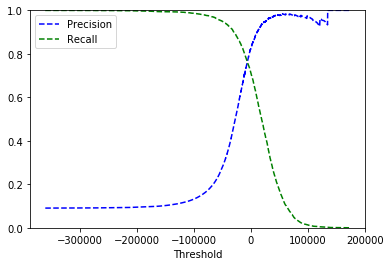

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

If we demand 90% precision, we see that the threshold needs to be moved to around 25000. However, the recall value will decrease and that is the tradeoff.

In [27]:
## alternative to  something like
# sgd_clf.predict(X_train, threshold=25000) ## check syntax
y_train_pred_90_perc = (y_scores > 25000)
precision_score(y_train_9, y_train_pred_90_perc)

0.9573964497041421

In [28]:
recall_score(y_train_9, y_train_pred_90_perc)  # not very good recall

0.4477033757609297

The relationship of precision and recall can be viewed using

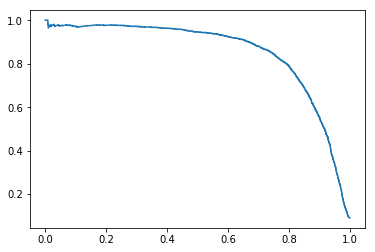

In [29]:
plt.plot(recalls, precisions)

### Reciver operating characteristic (ROC) curve

true positive rate vs false negative rate

False positive rate (FPR) =  Recall = TP/(total actual positive) =  
1 - true negative rate  = 1 - FN/(total actual positive)


In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

Plot the ROC curve.

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

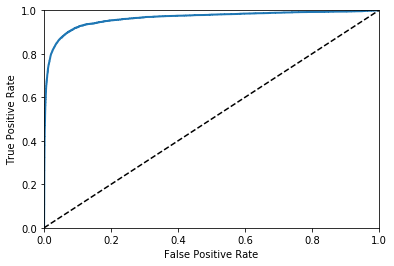

In [32]:
plot_roc_curve(fpr, tpr)

### TPR-FPR tradeoff
It is an increasing curve. If TPR goes up, so does FPR. But we want the curve to be away from the y=x line. Ideally the curve should have an area = 1 (which is max). The higher the area under the curve, the better the model.

Compute the area under the curve is `roc_auc_score`.

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9636743847715971

### Computing same values using `RandomForestClassifier`
It does not use `decision_function` but it uses `predict_proba` as a quantity to predict.

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=43)

# no need to fit because
# cross-validation actually fits it multiple times (cv times)
# to compute the score or prediction
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method='predict_proba')

In [35]:
y_probas_forest

array([[1. , 0. ],
       [0.1, 0.9],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

This `cross_val_predict` produces the probability that the given input belongs to the class `False` and `True` (in that order) with the given probability.

In [36]:
# using the probability of success as the score 
y_scores_forest = y_probas_forest[:,1]

In [37]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_9, y_scores_forest)

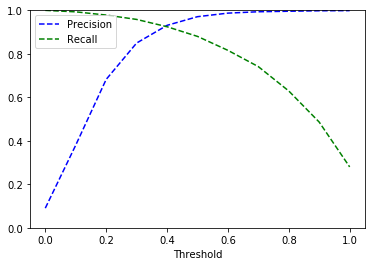

In [38]:
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)

As expected, the `RandomForestClassifier` is using `threshold` value 0.5 on the probalility of the `True` class to make prediction. So, we can definitely take the score as this probablility and default threshold 0.5.

0.9932121902442529

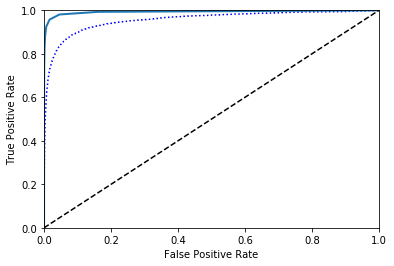

In [ ]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGC")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
roc_auc_score(y_train_9, y_scores_forest)

So, RandomForestClassifier has a better ROC-AUC score compared to SGDRegressor.

## Multiclass Classification
Classifiers automatically recognise that there are multiple classes to train. So, it runs multiple one-vs-all (OVA) classifiers. 

For example, in the code below, one classifier per class is trained and there are 10 of them. When an input is passed, the classifier with the maximum score is chosen to predict the class of input.

In [39]:
sgd_clf.fit(X_train, y_train) # SDG recognising multi-classes

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=43, shuffle=True, tol=53,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
sgd_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

 Use this multiclass SDG classifier to predict a random digit.

['7']


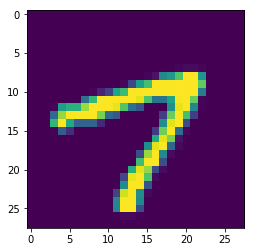

In [41]:
# sgd_clf.predict([some_digit]) syntax does not work since the
# argument requires an array of input arrays
# i.e. it is designed to work with matrices
print( sgd_clf.predict([X[101]]) )  # model works
plt.imshow(X[101].reshape(28,28))

['8']


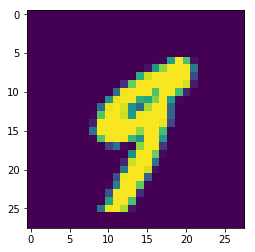

In [44]:
print( sgd_clf.predict([some_digit]) ) # model fails
plt.imshow(some_digit.reshape(28,28))

The prediction is wrong. Let us see what are the scores that the input belongs to each class?

In [45]:
for classname, score in zip(sgd_clf.classes_, sgd_clf.decision_function([some_digit]).reshape(-1)):
    print(classname,score)

0 -187921.09797349578
1 -162398.5305635771
2 -186973.57334983328
3 -27594.95278367299
4 -28386.620463784202
5 -19476.985237575183
6 -239183.89744545653
7 -41440.61033849762
8 -9747.321902622454
9 -29054.686085088702


Sorted by digits the models claims it is.

In [ ]:
# see code explanation in Digression below
sorted( zip(sgd_clf.classes_, sgd_clf.decision_function([some_digit]).reshape(-1)), key=lambda z: z[1], reverse=True )

[('3', -26749.353577864673),
 ('8', -27123.91009275578),
 ('9', -27194.766522679376),
 ('5', -45411.44037447553),
 ('4', -53609.079577372315),
 ('7', -53837.2562175764),
 ('2', -130202.66849546335),
 ('1', -157126.90425654568),
 ('6', -161944.82761481212),
 ('0', -182005.93184024663)]

So, `9` is the third choice, not even first or second.

## Digression
### Converting a matrix of order Nx1 to an array of order N
Use `reshape(-1)`. 

Surprisinginly, `reshape(N,1)` or `reshape(1,N)` does not work since the matrix-vector barrier is hard to break in python. The difference is between two square brackets vs one square bracket. It is not Matlab. See example:

In [ ]:
a = np.c_[[1, 2, 3, 4, 5]]
print(a)

[[1]
 [2]
 [3]
 [4]
 [5]]


In [ ]:
a.reshape(5,1)

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [ ]:
a.reshape(-1)

array([1, 2, 3, 4, 5])

### Zipping and sorting with respect to a column
`zip` function zips two arrays in their order and create a zipped variable. To sort them using a particular column, in `sorted()` function, use argument `key=lambda` and then a dummy array like `z`, followed by a semicolon and the column of that dummy array like this:

In [ ]:
an_ex = zip(['hello', 'how', 'are', 'you', 'doing'], [-1, 3, -2, 0 , 4])
sorted(an_ex, key=lambda p: p[1], reverse=True)

[('doing', 4), ('how', 3), ('you', 0), ('hello', -1), ('are', -2)]

## End of digression

### One vs One classification
Instead of (0 vs not-0), (1 vs not-1), ..., (9 vs not-9), we want to have (0 vs 1), (0 vs 2), ..., (0 vs 9), (1 vs 0), .... etc.

To use One-vs-One classifier option with `SDGClassifier()`, we need to use it as an argument of `OneVsOneClassifier()` class.

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=43, tol=53))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['4'], dtype=object)

In [ ]:
len(ovo_clf.estimators_)

45

In one-vs-one estimator, the classifier chooses a set of two classes and train one model for that set. So, for N classes, there are $N \choose 2$ classifiers. For $N=10$, we have $\frac{10 \times  9}{2} = 45$ classifiers.

### RandomForestClassifier does not require 1-vs-1 or 1-vs-All
It is good for categorizing inherently (for some reason).

In [46]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['9'], dtype=object)

Wow, much better than all the others so far, and without any extra option or argument!

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

This model is indeed very confident about its prediction.

### Use cross-valildation to evaluate multiclass models

I thougth that we are not using `cross_val_scoring` `'accuracy'` as a measurement for classifiers. What happened about that?

Maybe for  multiclassification, it is ok to use `cross_val_scoring`.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy' )

array([0.86837632, 0.88179409, 0.88748312])

### Scaling improved the accuracy of the multiclassifier (a trick from before)
We get better`cross_val_score`, if we scale the input to have zero mean and 1 standard-deviation.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91221756, 0.9120456 , 0.90778617])

In [ ]:
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.94191162, 0.94014701, 0.94164125])

### Going back to confusion matrix
* Get the cross-validation prediction (not score) usin `cross_val_predict`
* get the confusion matrix using ``confusion_matrix()``
Here, in the case of multi-classification, the matix will have 10 rows and 10 columns 

*Confusion Matrix* | Prediction: 0 | Prediction: 1 | ... | Prediction: 9
--- | ---- | --- | --- | ---
Actually: 0 | value | value | ... | value 
Actually: 1 | value | value | ... | value 
... | value | value | ... | value 
Actually: 9 | value | value | ... | value 



In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5735,    3,   20,   11,   11,   48,   45,    7,   39,    4],
       [   2, 6490,   46,   30,    6,   41,    6,   13,   98,   10],
       [  55,   36, 5347,  100,   84,   25,   86,   58,  152,   15],
       [  54,   42,  132, 5354,    3,  223,   38,   58,  136,   91],
       [  24,   29,   36,    9, 5383,    7,   50,   28,   87,  189],
       [  70,   39,   38,  190,   79, 4589,  113,   26,  181,   96],
       [  30,   26,   47,    2,   41,   92, 5628,    6,   46,    0],
       [  26,   20,   69,   29,   53,    9,    4, 5806,   16,  233],
       [  51,  158,   71,  160,   19,  140,   57,   22, 5043,  130],
       [  46,   34,   25,   86,  169,   32,    3,  206,   82, 5266]])

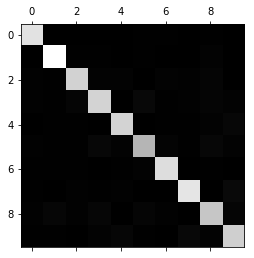

In [ ]:
plt.matshow(conf_mx, cmap='gray')

The matrix shows that wrong classification is is very less. However, we should scale the values to have the ratio of worngly classified classes.

The row-sum will give us the total number of elements that are actually in class corresponding to that row.

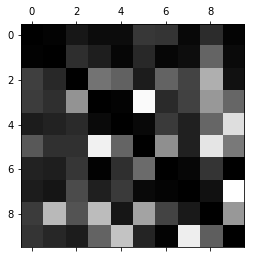

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
## setting the diagonal elements of the matrix zero
## so that the color range is scaled down for visibility
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='gray')

This show that there are a lot of
* 3 classified as 5
* 4 classified as 9
* 5 classified as 3
* 7 classified as 9

Also, 8 is most mistaken digit, also 5 and then 2 or 3 etc.

Interestingly, there are not many 1 classified as 7.



We do the same with `RandomForestClassifier`.

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)

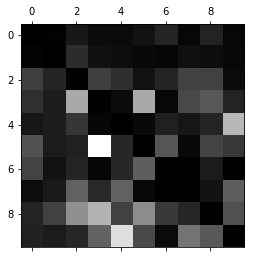

In [ ]:
confusion_mat_forest = confusion_matrix(y_train, y_train_pred_forest)
confusion_mat_forest_norm = confusion_mat_forest / confusion_mat_forest.sum( axis=1, keepdims=True)
np.fill_diagonal(confusion_mat_forest_norm, 0)
plt.matshow(confusion_mat_forest_norm, cmap='gray')

So, the 3/5 confusion still remains. Rotation, scaling, contrast etc affects the preformance of the classification.

## Multi-label classification
* We want our model to produce multiple outcomes for each input

Example: we want to print whether a given digit is
1. bigger than 5 or not
1. odd or even

Not every classifier offers multilabel classification. However, `KNeighborsClassifier` does.

### Converting numpy object array to integer
Use `.astype()`. If the array was just numpy array, we could have done something like `[int(num) for num in y_train]` but it does not work here since it is `dtype=ndarray`.

In [47]:
y_train_large = (y_train.astype(int) >= 6)
y_train_odd = (y_train.astype(int) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [48]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [49]:
knn_clf.predict([some_digit]) # the digit is 9, odd and bigger than 5

array([[ True,  True]])

### Measuring the preformance of multi-label classification
* F1 score for individual labels
* Avg of individual labels (we do this here)

First, we compute cross-validation prediction valuees, then compute the f1 score average.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [ ]:
f1_score(y_train, y_train_knn_pred, average='macro')

### MultiOutput Classification
The output will be a pixel brightness for each pixel. We are going to use this method to denoise images.

*The label is the input itself!!*
The model learns to recognise itself.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, X_train)

In [ ]:
plt.imshow(knn_clf.predict([X_train[40001]]).reshape(28,-1), cmap = 'gray')

In [ ]:
plt.imshow(X_train[40001].reshape(28,-1), cmap='gray')

### I created this bitmap image in Gimp with 28x28 dimension, with black background.
Due to the traing, the model tried to estimate each pixel by its nearest pixel suggested by the training. 

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('datasets/bit.bmp')
plt.imshow(img.reshape(28,28), cmap='gray')

In [ ]:
#img.reshape(-1)
plt.imshow(knn_clf.predict([img.reshape(-1)]).reshape(28,-1), cmap = 'gray')